# Table of contents

* [Competition Description](#description) 
* [1. Data Munging](#munging)
 * [1.1 Initial Look and Cleaning](#initial)
 * [1.2 Explore NaNs and Fill](#nans)
 * [1.3 TODO](#1todo)
* [2. EDA](#eda)
 * [2.1 Individual feature examination](#feature)
 * [2.2 Dependent variable examination (SalePrice)](#dependent)
 * [2.3 Transform categorical data to dummy variables](#transform)
 * [2.4 TODO](#2todo)
* [3. Modeling](#modeling)
 * [3.1 Model Selection](#selection)
 * [3.2 Closing notes](#closing)
 * [3.3 TODO](#3todo)

<a id='description'></a>
# Competition Description
### (In case you are unfamiliar with the project)
From Kaggle:

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

### Practice Skills
Creative feature engineering 
Advanced regression techniques like random forest and gradient boosting
### Acknowledgments
The Ames Housing dataset was compiled by Dean De Cock for use in data science education. It's an incredible alternative for data scientists looking for a modernized and expanded version of the often cited Boston Housing dataset.
### Goal
It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable. 
### Metric
Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)
<a id='munging'></a>
# 1. Data Munging

You can find all the code and datasets on my [project github](https://github.com/stevendevan/KaggleHousePrices).

My code is more modularized there, but I will reproduce the functions in this notebook so you can see the source code.
<a id='initial'></a>
### 1.1 Initial Look and Cleaning
First of all we'll import some modules for plotting and data manipulation, and call our bread-and-butter head() function.

In [19]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [9, 6]

infolder = 'data/input/'
outfolder = 'data/output/'

df_train_raw = pd.read_csv(infolder + 'train.csv')
df_test_raw = pd.read_csv(infolder +  'test.csv')

print('Training data: {s[0]} rows, {s[1]} columns'.format(s=df_train_raw.shape))
print('Testing data: {s[0]} rows, {s[1]} columns'.format(s=df_test_raw.shape))
df_train_raw.head()

Training data: 1460 rows, 81 columns
Testing data: 1459 rows, 80 columns


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


As it's always useful to learn more about the data itself, how it was collected, etc., let's check out the [documentation.](http://ww2.amstat.org/publications/jse/v19n3/Decock/DataDocumentation.txt)
Toward the bottom, under the 'Special Notes' section, the author recommends removing any observations for which GrLivArea > 4000, as he says those can safely be considered true anomalies. Let's do that now.

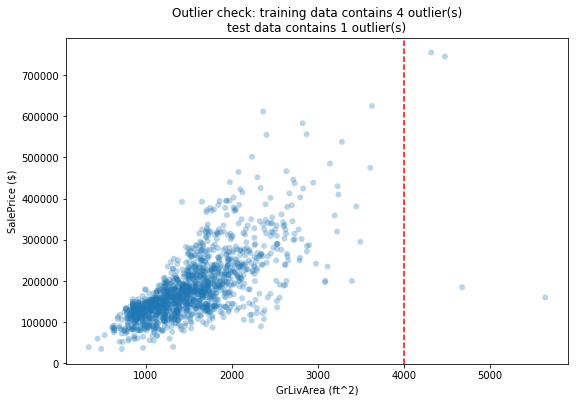

In [20]:
plt.scatter(df_train_raw['GrLivArea'], df_train_raw['SalePrice'],
            alpha=0.3, edgecolor='none');
plt.axvline(4000, ls='--', c='r');
plt.title('Outlier check: training data contains {} outlier(s)\n'
          'test data contains {} outlier(s)'
          .format(sum(df_train_raw['GrLivArea'] > 4000),
                  sum(df_test_raw['GrLivArea'] > 4000)));
plt.xlabel('GrLivArea (ft^2)');
plt.ylabel('SalePrice ($)');

# The big moment. Don't forget to reset the index.
df_train_raw.drop(df_train_raw[(df_train_raw['GrLivArea'] > 4000)].index, 
                  inplace=True)
df_train_raw.reset_index(inplace=True, drop=True)

Now let's spearate out the dependent variable and concatenate both the train and test data for null investigation and convenient cleaning.

In [21]:
y = df_train_raw['SalePrice'] # Dependent variable
df_train_raw.drop(['SalePrice'], axis=1, inplace=True)

ntrain = df_train_raw.shape[0] # so we can split the data back up later

df_all_raw = pd.concat([df_train_raw, df_test_raw], ignore_index=True)

<a id='nans'></a>
### 1.2 Explore NaNs and Fill
Here I will reproduce the primary data conditioning function that I use. I will then elaborate on some of the actions in the function and include example plots. It is critical that you take a look at the [data_description file]( provided with the data on the Kaggle website), as it clarifies most of what we'll have to do for the NaN-filling work.

In [22]:
def condition_housing_data(df):
    """General data-conditioning function to prepare the housing DataFrame for
    analysis. Mostly NaN filling
    """

    fillnone = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish',
                'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature',
                'MasVnrType']

    fillzero = ['GarageArea', 'TotalBsmtSF', 'LotFrontage', 'MasVnrArea',
                'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea']

    fillmode = ['Electrical', 'KitchenQual', 'SaleType', 'Exterior1st',
                'Exterior2nd', 'Functional', 'MasVnrType', 'MSZoning']

    # has some NaNs. Value is highly correlated with YearBuilt
    df['GarageYrBlt'].fillna(df['YearBuilt'], inplace=True)

    # There seems to be an erroneous value for GarageYrBlt of 2207
    # Based on the YearBuilt being 2006, I assume it should be 2007
    df.loc[df.GarageYrBlt == 2207.0, 'GarageYrBlt'] = 2007.0

    # Convert column to strings. It's categorical data stored as int64
    df['MSSubClass'] = df['MSSubClass'].astype(str)

    # Really only one value present
    df.drop(['Utilities'], axis=1, inplace=True)

    # Apparently this can't be done without looping.
    for colname in fillnone:
        df[colname].fillna('none', inplace=True)

    for colname in fillzero:
        df[colname].fillna(0, inplace=True)

    for colname in fillmode:
        df[colname].fillna(df[colname].mode()[0], inplace=True)

    return df


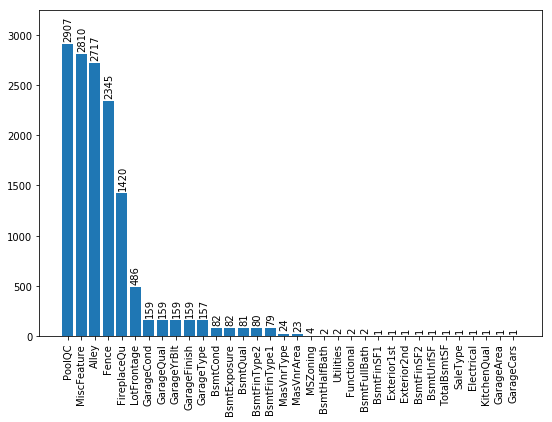

In [23]:
nullcols = df_all_raw.isnull().sum(axis=0).sort_values(ascending=False)
nullcols = nullcols[nullcols > 0]

plt.bar(nullcols.index, nullcols);
plt.ylim(0, 3250)
for xpos, ypos in enumerate(nullcols.values):
    plt.text(xpos + .06, ypos + 30, str(ypos), 
             ha='center', va='bottom', rotation=90, color='black');
plt.xticks(range(len(nullcols)), nullcols.index, rotation=90);

We can see from the plot above that the vast majority of NaNs fall into the fillnone category, which is very convenient. I wouldn't even consider NaNs in those features as 'missing', but rather just requiring a conversion to string.

As noted in the function comments, 'MSSubClass' is a categorical variable stored as int64. A simple conversion to string fixes this.

The training set effectively only contains one value for 'Utilities', making it useless for analysis.

In [24]:
print(df_train_raw['Utilities'].groupby(df_train_raw['Utilities']).count() \
                               .sort_values(ascending=False))

Utilities
AllPub    1455
NoSeWa       1
Name: Utilities, dtype: int64


There appears to be a garage from the future. We will assume it was meant to be 200X, not 220X. 


Also, we can see from the plot below that in most cases, the year the house was built and the year the garage was built are the same, making 'YearBuilt' a suitable NaN filler for 'GarageYrBlt'

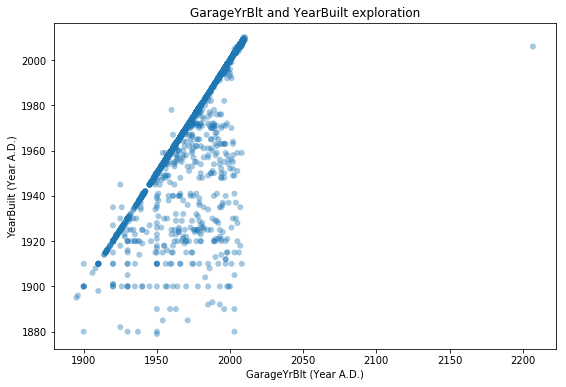

In [25]:
plt.scatter(df_all_raw['GarageYrBlt'], df_all_raw['YearBuilt'],
            alpha=0.4, edgecolor='none');
plt.title('GarageYrBlt and YearBuilt exploration');
plt.xlabel('GarageYrBlt (Year A.D.)');
plt.ylabel('YearBuilt (Year A.D.)');

NaN filling the rest of the data is pretty straightforward. We can split the remaining features into 3 categories that I call **fillnone**, **fillzero**, and **fillmode**. 

Going through the description of each variable in the data_description.txt file, some of the features indicate that NA just means that a property doesn't have that feature. We can treat this as a category in itself and fill those NaNs with the string 'none'.

For some NaNs in numerical features, this usually means that there is zero of that feature, e.g. zero square feet or zero bathrooms. In these cases, we will fill NaNs with zero.

Finally, there are some categorical features for which a NaN has no obvious meaning. Many of these features are dominated by a single value, so we will fill those NaNs with the mode value.
### So let's go ahead and condition the data

In [26]:
df_all = condition_housing_data(df_all_raw)
print('There are now {} null values in the data.'
      .format(df_all.isnull().sum().sum()))

# split the DataFrames back up for analysis
df_train = df_all[:ntrain]
df_test = df_all[ntrain:]

There are now 0 null values in the data.


<a id='1todo'></a>
### 1.3 TODO
A potential improvement could be a more sophisitcated NaN filler for the fillmode features. This could potentially be a predictive modeling task in itself.

<a id='eda'></a>
## 2. EDA
<a id='feature'></a>
### 2.1 Individual feature examination
When I first approach a dataset, I like to look at the distributions of the individual features and their relationship to the dependent variable(s). Here are a couple of functions to loop through all the features and plot information about them. I won't call them here because we'd end up with 80 plots, but if you want to make the plunge, go for it.

In [27]:
def explore_categorical(df):

    plt.rc('figure', figsize=(10.0, 5.0))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # discard non-object data
    df_ob = df.loc[:, df.dtypes == 'object'].fillna('none')

    for column in df_ob.columns:

        values = df_ob[column].groupby(
            df_ob[column]).count().sort_values(ascending=False)

        fig1, (ax11, ax12) = plt.subplots(1, 2)
        plt.suptitle(column)
        ax11.bar(values.index, values.values, color=colors)
        plt.title('Feature value counts')
        ax11.set_xlabel('Feature value')
        ax11.set_ylabel('Count')

        for label in values.index:

            data = df.loc[df_ob[column] == label, 'SalePrice'].values
            if len(data) > 1:
                sns.distplot(data, hist=False, ax=ax12)
                plt.title('PDF per feature-value')
                ax12.set_xlabel('SalePrice ($)')
                ax12.set_ylabel('Relative requency of occurance\n'
                                'Units are not that useful')
                ax12.set_yticks([])
                # Maybe consider CDF as an alternative
                # data.hist(bins=len(data), cumulative=True,
                #          density=True, histtype='step')

        plt.show()
        
        
def explore_numerical(df):

    df_num = df.loc[:, df.dtypes != 'object']
    df_num.fillna(0, inplace=True)
    #df_num.drop(labels='Id', axis=1, inplace=True)

    for column in df_num.columns:
        plt.scatter(df_num[column].values, df_num['SalePrice'].values,
                    alpha=0.4, edgecolors='none')
        plt.title(column)
        plt.xlabel(column)
        plt.ylabel('SalePrice ($)')
        plt.show()

Take a quick look at the correlation heatmap. I sort the bottom row to better visualize which features are likely to affect SalePrice the most. The 1.0 diagonal gets a bit jumbled, but that's ok. Notice the collinearity in many of the variables, such as within all the garage variables. This will influence the choice of linear model later on.

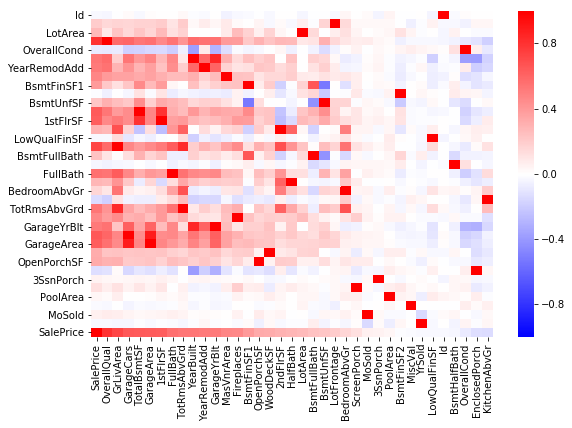

In [28]:
sns.heatmap(pd.concat([df_train, y], axis=1).corr().sort_values('SalePrice', 
                                                                axis=1,
                                                                ascending=False,),
            vmin=-1.0,
            vmax=1.0,
            cmap='bwr');

If we run the exploration functions above and look at the plots, we can see the consequences of filling NaN values in numerical features with zero. Here's an example.

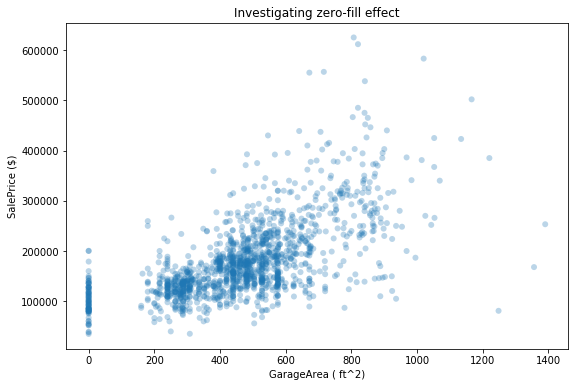

In [29]:
plt.scatter(df_train['GarageArea'], y, alpha=0.3,
            edgecolor='none');
plt.title('Investigating zero-fill effect');
plt.xlabel('GarageArea ( ft^2)');
plt.ylabel('SalePrice ($)');

Depending on the feature's relationship with the dependent variable, this separation/grouping may have an adverse effect on the model. It'll be in my todo section to investigate this further.
<a id='dependent'></a>
### 2.2 Dependent variable examination (SalePrice)
What many kernels I've seen will do at this point is examine the skewness of the dependent variable. First we'll check the skewness using scipy.stats.skew, which uses the Pearson's Moment Coefficient of Skewness. The source formula is linked in the [function documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html) and you can read more about skew metrics on [wikipedia](https://en.wikipedia.org/wiki/Skewness#Pearson's_moment_coefficient_of_skewness). Pearson's **Mode** coefficient of skewness also seems to be popular.

Pearson's moment coefficient of skewness for SalePrice: 1.564345548419458


c:\_programs\python 3.6.3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


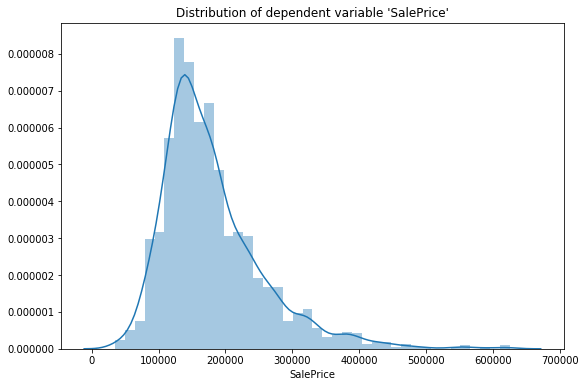

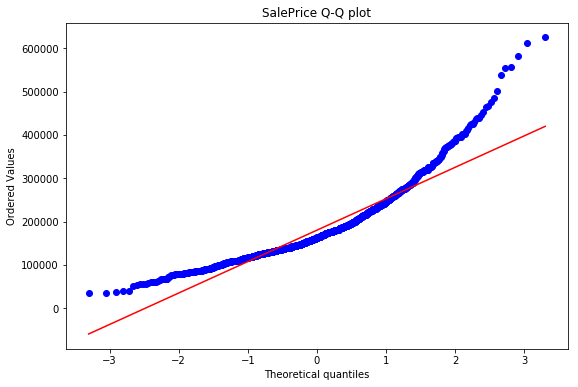

In [30]:
print('Pearson\'s moment coefficient of skewness for SalePrice: {}'
      .format(stats.skew(y)))

# And let's plot the SalePrice distribution so we can see what that looks like.
sns.distplot(y);
plt.title('Distribution of dependent variable \'SalePrice\'');

# And a Q-Q plot for good measure
plt.figure();
stats.probplot(y, dist='norm', plot=plt);
plt.title('SalePrice Q-Q plot');

As we can see from the plot above, SalePrice does look skewed. Also note the Quantile-Quantile (Q-Q) plot, which compares the actual distribution of SalePrice to a theoretical perfect normal distribution. If SalePrice were normally distributed, all points would lie on the red line. I first encountered these in other Kagglers' kernels, and the [Wikipedia Q-Q plot article](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot) helped me understand a bit better. 

But how skewed is a coefficient of 1.5? At what threshold do we decide we need to take action? [This ResearchGate discussion](https://www.researchgate.net/post/What_is_the_acceptable_range_of_skewness_and_kurtosis_for_normal_distribution_of_data) says +/- 2 is a good threshold, but it isn't clear what metric the posters are using. There are also some sources cited on there, but I could not access them. Some other kernels for this competition use thresholds in the 0.75 - 1.0 range to say that a distribution is skewed. As with many things, the real answer is "it depends".

As I said, I've seen a few good kernels investigate the skewness of SalePrice and apply a log transformation to make the variable more normal. What these kernels do not do very well is explain why. After some research, it seems that the distribution of the features and dependent variable do not need to be normal at all. What **does** need to be normal are the residuals. If the residuals are not normally distributed about zero, that means our model may not be appropriate for the data. You can read a quick explanation [in this blog article](http://thestatsgeek.com/2013/08/07/assumptions-for-linear-regression/)

So let's see what happens when we take the log of SalePrice:

Pearson's moment coefficient of skewness for transformed SalePrice: 0.06539261154401074


c:\_programs\python 3.6.3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


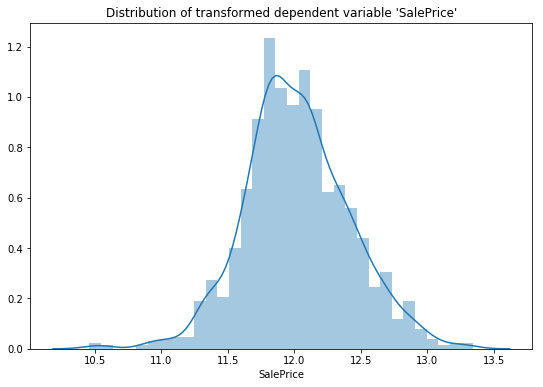

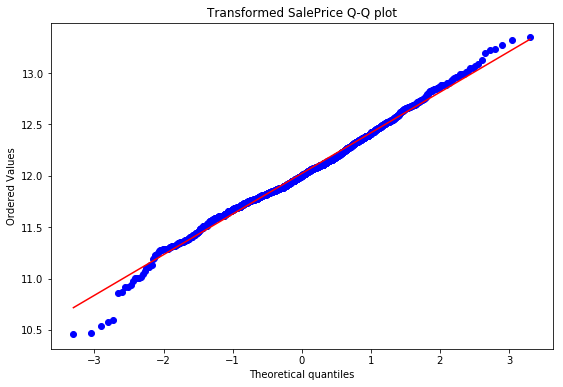

In [31]:
y_log = np.log1p(y)

print('Pearson\'s moment coefficient of skewness for transformed SalePrice: {}'
      .format(stats.skew(y_log)))

# And let's plot the SalePrice distribution so we can see what that looks like.
sns.distplot(y_log);
plt.title('Distribution of transformed dependent variable \'SalePrice\'');

# And a Q-Q plot for good measure
plt.figure();
stats.probplot(y_log, dist='norm', plot=plt);
plt.title('Transformed SalePrice Q-Q plot');

Wow, the skewness coefficient is much lower, and the Q-Q plot follows the "normality line" much more closely.

Great, but didn't we just see that it isn't neccesary to make SalePrice more normally distributed? **It turns out that taking the log of SalePrice actually makes its relationship with many of the numerical feature variables more linear, i.e. better suited for linear regression.**

I'll give you some examples.

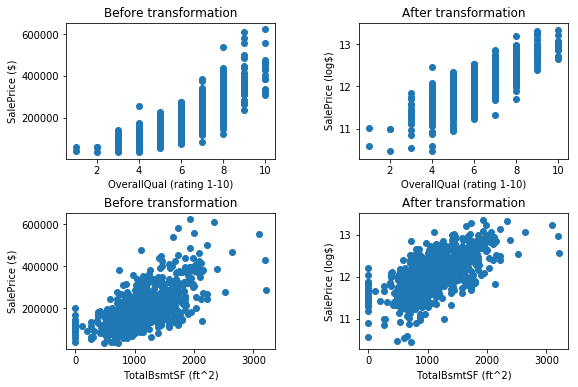

In [32]:
plt.figure();
plt.subplots_adjust(wspace=.4, hspace=.4)
plt.subplot(221);
plt.scatter(df_train['OverallQual'], y);
plt.title('Before transformation');
plt.xlabel('OverallQual (rating 1-10)');
plt.ylabel('SalePrice ($)');

plt.subplot(222);
plt.scatter(df_train['OverallQual'], y_log);
plt.title('After transformation');
plt.xlabel('OverallQual (rating 1-10)');
plt.ylabel('SalePrice (log$)');

plt.subplot(223);
plt.scatter(df_train['TotalBsmtSF'], y);
plt.title('Before transformation');
plt.xlabel('TotalBsmtSF (ft^2)');
plt.ylabel('SalePrice ($)');

plt.subplot(224);
plt.scatter(df_train['TotalBsmtSF'], y_log);
plt.title('After transformation');
plt.xlabel('TotalBsmtSF (ft^2)');
plt.ylabel('SalePrice (log$)');

As we can see, applying a log transform to SalePrice results in a more linear relationship with **at least some** variables. This may not be true for all, and  it would be worth investigating whether individually tweaking each variable's fit would be more effective than just transforming the dependent variable.
<a id='transform'></a>
### 2.3 Transform categorical data to dummy variables
Pandas provides convenient DataFrame methods to dummify data. Here's a simple function to dummify all our categorical data.

In [33]:
def dummify_data(df):

    categoricals = df.columns[df.dtypes == 'object']
    df_new = df.drop(categoricals, axis=1)
    df_new = pd.concat([df_new, pd.get_dummies(df[categoricals])],
                       axis=1)

    return df_new


df_all_dummified = dummify_data(df_all)
df_all_dummified.head()
df_all_dummified.shape

# split the data back up
Xtrain = df_all_dummified[:ntrain]
Xtest = df_all_dummified[ntrain:]

<a id='2todo'></a>
### 2.4 TODO
Consider separating houses with/without garages and basements for analysis. Especially in variables like 'TotalBsmtSF' and 'GarageArea', there will be a cluster of values with value 0, and it may be negatively affeccting regression.
<a id='modeling'></a>
## 3. Modeling
<a id='selection'></a>
### 3.1 Model Selection
Cool. Looks like we've got the data prepped and ready. So what model do we choose? Recall the correlation heatmap shown in section 2.1, and the significant collinearity between some of the variables. As you may know, LASSO tends to zero out feature coefficients, while Ridge results in small, yet non-zero coefficients. I'll quote this good [comparison of LASSO and Ridge regression from AnalyticsVidhya](https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/):

> [Ridge regression] generally works well even in presence of highly correlated features as it will include all of them in the model but the coefficients will be distributed among them depending on the correlation.

Given the presence of highly correlated variables in our dataset, that sounds like what we need. This is not to say LASSO would not aslo work, just that Ridge is more appropriate.

First off, let's make our own custom cross validation function. Sometimes the built-in sklearn functions will work out of the box (cross_val_score, RidgeCV, etc.) and sometimes you'll have to wrap them in your own function.

We're using "neg_mean_squared_error" and not "neg_mean_squared_log_error" because SalePrice already has a log applied to it. Then we have to take the square root to get our RMSE.

In [34]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import Ridge

def RidgeCV_custom(model_ridge, alphas, X, y):
    """We are assuming y (SalePrice) has already been log transformed"""
    scores = pd.DataFrame()
    for alpha in alphas:
        model_ridge.alpha = alpha
        scores_temp = cross_val_score(model_ridge,
                                      X,
                                      y,
                                      cv=5,
                                      scoring='neg_mean_squared_error')
        scores['{}'.format(alpha)] = np.sqrt(-scores_temp)
        
    return scores

# Randomize the data since cross_val_score doesn't
randstate = 4
Xtrain_rand = Xtrain.sample(frac=1, random_state=randstate)
y_log_rand = y_log.sample(frac=1, random_state=randstate)

model_ridge = Ridge(alpha=.1,
                    normalize=True,
                    max_iter=1e5)
alphas = [.0001, .001, .01, .1, 1, 10]
cv_test_1 = RidgeCV_custom(model_ridge, alphas, Xtrain_rand, y_log_rand)
cv_test_1

,0.0001,0.001,0.01,0.1,1,10
0,0.127722,0.127638,0.126787,0.121808,0.120869,0.199444
1,0.138271,0.137696,0.134188,0.125678,0.127776,0.206924
2,0.124512,0.124238,0.122291,0.116781,0.122218,0.193772
3,0.122001,0.121325,0.118584,0.114045,0.122205,0.206136
4,0.129314,0.128821,0.126270,0.122850,0.130620,0.210036


Looks like alpha = 0.1 performs the best. Let's increase the resolution around that value and do a final check.

In [35]:
randstate = 10
Xtrain_rand = Xtrain.sample(frac=1, random_state=randstate)
y_log_rand = y_log.sample(frac=1, random_state=randstate)

alphas = [.01, .05, .1, .5, 1]
cv_test_2 = RidgeCV_custom(model_ridge, alphas, Xtrain_rand, y_log_rand)
cv_test_2

,0.01,0.05,0.1,0.5,1
0,0.130894,0.123795,0.120152,0.116708,0.120516
1,0.129579,0.126988,0.126861,0.134112,0.143811
2,0.137208,0.131542,0.128046,0.120108,0.120666
3,0.134670,0.126387,0.123276,0.120164,0.124321
4,0.119552,0.114466,0.111566,0.108847,0.113024


0.1 still seems to be the best pick. Let's look at the cross-validated residuals.

Normality of residuals a la Shapiro-Wilk test (W = 1.0 -> perfectly normal) 
W statistic: 0.9262474775314331
p-value: 3.7878287270250226e-26


c:\_programs\python 3.6.3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


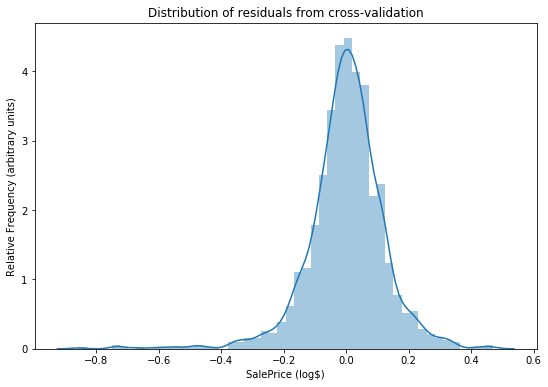

In [36]:
residuals = y_log_rand - cross_val_predict(model_ridge,
                                           Xtrain_rand,
                                           y_log_rand,
                                           cv=5)

print('Normality of residuals a la Shapiro-Wilk test (W = 1.0 -> perfectly normal) \n'
      'W statistic: {vals[0]}\n'
      'p-value: {vals[1]}'
       .format(vals=stats.shapiro(residuals)))

sns.distplot(residuals);
plt.title('Distribution of residuals from cross-validation');
plt.xlabel('SalePrice (log$)');
plt.ylabel('Relative Frequency (arbitrary units)');

The W coefficient from the S-W test is very close to 1, which is a good sign. Normally distributed residuals indicate that a linear model is appropriate.

So to conclude, we'll be using a Ridge regression model with normalization and an alpha value of 0.1, as determined by our custom cross-validation function. [sklearn's GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) is also worth looking into. When using Ridge, we must set the normalize parameter to True so that Ridge's penalization affects all coefficients evenly.
<a id='closing'></a>
### 3.2 Closing notes
From here, we would simply fit all of the training data to our model, and then call the predict function and create our formatted submission csv.

As you can see, data cleaning and EDA make up most of the work. The quality of and thought behind your cleaning/EDA phase can make or break your model. SKLearn has loads of tools for model validation, which means that model selection relies mostly on your statistical expertise. I hope this notebook shed some light on such topics such as Ridge regression and the EDA thought process. I highly encourage you to read through the links I provided throughout if you're still fuzzy on any of these topics.
<a id='3todo'></a>
### 3.3 TODO
I did not document them here yet, but I also attempted to use adaboost and decision tree regressor model types. None of those results beat out my Ridge model, so it may be worth finding out why, exactly. I really thought the tree regressor would work better, so it may be a flaw in my understanding or model hyperparameters.

# END
Thanks for reading!